# Prvi zadatak: implmentiraj LR i pusti da trenira dosta dugo. Posle toga:
1. napravi toy dataset
2. napravi veliki dataset

# ZA Scheduler:
stepuj ga svako malo, ne kao u tutorijalu.
Testiraj prvo malo lambda_LR

In [19]:
#import numpy as np # linear algebra
from math import sqrt
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor, full, save as torchsave, load as torchload, cuda, int as torchint, zeros
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
#upali internet
toker = AutoTokenizer.from_pretrained("openai-community/gpt2")
nice = toker("<|endoftext|>")
#videcemo posle sta nam jos treba

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


*Za resenje pogledaj greedy decode funkciju. Ima nesto out[:,-1]
Imamo i BLANK_WORD = "\<blank\>". Pogledaj src i tgt sta su, deluje korisno.*
*set_default_device*
# SAMO RUNUJ KOD sa githuba.
removuj iz linuxa prvo pa u D. valjda ce da radi...

*In my case the issue appeared to be that the dtype of the initial hidden state was a double and the input was a float. I don’t quite understand why that is an issue, but casting the hidden state to a float solved the issue. If you have any intuition about why this might be a problem for PyTorch, do let me know in the comments.*

#LABEL SMOOTHING TI FALI

# PAZI! layer norm treba jednom posle MHA i jednom posle FF

In [20]:
gpu = torch.device('cpu')
TRAIN_INPUT = '/kaggle/input/shakespeare/encoded_train_file.pkl'
TEST_INPUT = '/kaggle/input/shakespeare/encoded_test_file.pkl'
MAX_CONTEXT = 99
MIN_CONTEXT=19
NO_TEST_STRINGS=1000

In [21]:
#slobodno run-uj

EOF = toker("<|endoftext|>")['input_ids'][0]
NONE = 0
vocab_size = 50257
d=512 #dimenzija
dk = 64
heads = 8
sqrtd = float(sqrt(d))
lr=2e-6
POS_DROPOUT=0.1
NN_DROPOUT=0.1
warmup = 1000

#Very important u annotated transformer je ovaj scheduling. Stavi to cim nesto istrenita.

trainpath = '/kaggle/input/shakespeare/train.txt' #train data
ENC_INPUT = '/kaggle/input/shakespeare/encoded_file.pkl'
ENC_OUTPUT = '/kaggle/working/encoded_file.pkl'
N_TOKENS = 1689337
def tokenize():
    raise Exception("already done")
    max_context = N_TOKENS+10
    curr_context = 0
    reached_lim = False
    context = full((max_context,), EOF, dtype=torchint, device=gpu)
    with open(trainpath,'r') as f:
        for line in f:
            new_ids = toker(line)['input_ids']
            new_len = len(new_ids)
            if(curr_context+new_len>max_context):
                reached_lim=True
            if reached_lim: break
            context[curr_context:curr_context+new_len]=tensor(new_ids)
            curr_context+=new_len
        torchsave(context, ENC_OUTPUT)
        # print(curr_context)
#     inp = F.one_hot(context, vocab_size)
#     print(f'{inp.shape=}')


In [22]:
import matplotlib.pyplot as plt
mask= torch.arange(0,120,1).view(1,120).expand(120,120) - torch.arange(0,120,1).view(120,1).expand(120,120) > 0
class Tf(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedder = nn.Linear(vocab_size, d,bias=False, device=gpu)
        self.dembedder = nn.Linear(d, vocab_size, bias=False, device=gpu)
        self.dembedder.weight = nn.Parameter(self.embedder.weight.t())
        self.layer_norm = nn.LayerNorm((d,), device=gpu)
        self.pos_dropout = nn.Dropout(POS_DROPOUT)
        self.nn_dropout = nn.Dropout(NN_DROPOUT)
        self.N=6

        self.feedforwards = nn.ModuleList([nn.Sequential(nn.Linear(d,4*d, device=gpu), nn.ReLU(), nn.Linear(4*d,d, device=gpu), nn.ReLU())
                       for _ in range(self.N)])
        self.queries = nn.ModuleList([nn.Linear(d,heads*dk,device=gpu) for _ in range(self.N)])
        self.keys = nn.ModuleList([nn.Linear(d,heads*dk,device=gpu) for _ in range(self.N)])
        self.values = nn.ModuleList([nn.Linear(d,heads*dk,device=gpu) for _ in range(self.N)])
        self.qksoftmax = nn.Softmax(-1)
        #Q=Qnn @ Hi=[len, heads, dk]. Q[i] je MH query.
        #
        #Qnn =  [heads,dk]
        # mozda::::::Qnn in=d, out=heads*dk
        #K = Knn*H = [len,heads,dk]
        #QK = Q dot K (kako?) = [len,len,heads]
        #Naime QK[i] = matrica proporcije za i-ti element.
        #QK[i]=sumj(Q[i] dot-po-dk K[j]) OVO NE ZVUCI TACNO
        #QK[i,j]=sumx(Q[i,:,x]*K[j,:,x]). Nadam se da ovde lepo radi broadcasting

        # H L D, H D L -> H L L moze. Koristi .transpose(dim0, dim1) da bi sredio ovo.

        #V=Vnn*H = [len,heads,dk]
        #MHO = [len, heads, dk]
        #MHO[i,h] = sumj(QK[i,j,h]*V[j,h])
        #MHO = QK(T!) dot VT
        #QKT = [h,l,l]; VT = [h,l,d]
        #O = [len, d] = MHO.squeeze(1,0) #uradi ovo sa view
        #H = [len,d]
        #Hi = [len,d,1]
        #Kako se inace oznacavaju neuralne sa matricnim mnozenjem.......
        #Mi zavrsimo sa jednim sequencom emb O[len,d]. O[i] = sum()
    def add_pos_embedding(self, a, predict_pos):
        #print(f'{a.abs().mean()=}')

        lin = torch.arange(0,a.shape[-2],1,device=gpu).unsqueeze(1).to(gpu).expand(a.shape[-2],d)
        pows = torch.arange(0,1,1/d).unsqueeze(0).to(gpu).expand(a.shape[-2],d)
        pows = torch.pow(0.0001, pows)
        print(f'{pows.shape=}')
        print(f'{lin.shape=}')
        fin = torch.sin(lin * pows)
        fin[::2] = torch.cos(pows)[::2]
        #print(f'{fin.requires_grad=}')
        fig,ax = plt.subplots(1,1)
        ax = plt.imshow(fin.numpy())
        fig.savefig('fin.png')
        print("sacuvao")
        a=a+(fin)
        #print(f'{fin.abs().mean()=}')
        return self.pos_dropout(a.float())




    #treba i za ovo dropout...


    def mha(self,vnnres,knnres,qnnres, d, dk, heads):
        # print(f'{knnres.shape=}')
        # print(f'{vnnres.shape=}')
        # print(f'{qnnres.shape=}')
        l = knnres.shape[-2]
        assert(d==dk*heads)
        v = vnnres.view(l,heads,dk).transpose(-2,-3)
        #print(f'{v=}')
        q = qnnres.view(l,heads,dk)
        #print(f'{q=}')
        k = knnres.view(l,heads,dk)
        #print(f'{k=}')
        k = k.transpose(-3,-2).transpose(-2,-1)
        #print(f'{k=}')
        q = q.transpose(-3,-2)
        #print(f'{q=}')
        qk = torch.matmul(q,k)
        #print(f'{qk=}')
        qk = qk / float(sqrt(dk))
        qk[:,mask[:l,:l]] = float('-inf')
        #print(f'{qk=}')
        qk = self.qksoftmax(qk)
        #print(f'{qk=}')
        o = torch.matmul(qk,v)
        #print(f'{o=}')
        o = o.transpose(-3,-2).reshape((1,l,d)) #ovde je bilo (bat,l,d)
        #print(f'{o=}')
        return o
    def testmha(self):
      #probaj s manjim dimenzijama, stavi neki if za testiranje
        l = 5
        d = 6
        dk=3
        heads=2
        vnnres = (torch.rand((l,d),device=gpu)*5).int().float()
        knnres = (torch.rand((l,d),device=gpu)*5).int().float()
        qnnres = (torch.rand((l,d),device=gpu)*5).int().float()
        print(f'{vnnres=}')
        print(f'{knnres=}')
        print(f'{qnnres=}')
        self.mha(vnnres,knnres,qnnres,d,dk,heads)
    def attentionstack(self,h):
        for i in range(self.N):
            q = self.queries[i](h)
            k = self.keys[i](h)
            v = self.values[i](h)
            h = self.mha(v,k,q,d,dk,heads)
            h = self.layer_norm(h+self.nn_dropout(self.feedforwards[i](h)))
        return h
    def test_embedding(self, h):
        predict_pos = h.shape[-1]-1
        #print(f'{h=} pre one_hot')
        h = F.one_hot(h, vocab_size).float()
        #print(f'{h.requires_grad=} {h.device=}  nakon one_hot')
        h = (self.embedder(h)*sqrtd).float()
        #Ovde krene requires_grad=True. Ppvljam zato sto je ovaj grad bitan za embedder a ostalo nije bitno.
        #print(f'{h.requires_grad=} {h.device=}  nakon embedder')
        h = self.add_pos_embedding(h, predict_pos)
    def forward(self, h):
#         h[:-1] = encoded_input #realno ga kopira
        predict_pos = h.shape[-1]-1
        #print(f'{h=} pre one_hot')
        h = F.one_hot(h, vocab_size).float()
        #print(f'{h.requires_grad=} {h.device=}  nakon one_hot')
        h = (self.embedder(h)*sqrtd).float()
        #Ovde krene requires_grad=True. Ppvljam zato sto je ovaj grad bitan za embedder a ostalo nije bitno.
        #print(f'{h.requires_grad=} {h.device=}  nakon embedder')
        h = self.add_pos_embedding(h, predict_pos)
        #ovde neko matricno mnozenje da bi konacno interagovale stvari
        #jao cekaj treba multi sranje. A kako je annotated napravio liste jbm ga
        #samo procitaj rad molim te ima nekih korenova



        #print(f'{h.requires_grad=} nakon pos emb')


        h = self.attentionstack(h) #ne moramo jos...


        #print(f'{h.shape=} nakon attlayers')
        h = self.dembedder(h[:,predict_pos])
        #print(f'{h.requires_grad=} nakon dembedder')
        #uradi dropout
        return h

## Procitaj sta je layer normalization

### MISLIM DA MOZE SVE DA BUDE H. Pitaj nekoga kako to.
Rekao bih da += ne pravi kopiju u memoriji koja se cuva za graf, a a=a+x ili a= self.conv(a) radi to. Medjutim zasto to u forumu nije ponudjeno kao laki fiks?

### Nadji mesto gde decoder smanjuje dimenziju tenzora

### Sta ako on dobije sequence "Ja idem u \_" i onda tu donju-crtu pretvori u nesto? I onda pogleda samo taj token na kraju.

Od kog tokena se krece? Sve nule u embedingu?

## Dodaj learning rate majke ti
## Sta je loss.item(). Nigde nisu sumovali nista

## Bezi bre zasto nisam za test_input stavio jos +max context ?

In [23]:

def train_test_split():
    raise Exception("already done")
    t = torchload(ENC_INPUT)
    torchsave(t[:-(MAX_CONTEXT+NO_TEST_STRINGS)].clone(),TRAIN_INPUT)
    torchsave(t[-(MAX_CONTEXT+NO_TEST_STRINGS):].clone(), TEST_INPUT)

Why linear tako jadno

In [24]:


class VerseDataset(Dataset):
    def __init__(self, length):
        super().__init__()
        self.t = torch.zeros((length,),device=gpu).long()
        self.t[1::3] = 1
        self.t[2::3]=2
        self.rnd_modifier = 0
    def __getitem__(self,i):
        i+=MAX_CONTEXT+1
        conlen = (((i+self.rnd_modifier)%5)+1)*20-1

        h = (self.t[i-conlen:i]).long()#,device=gpu,dtype=torch.float32, requires_grad=True
        return (h, (self.t[i]).long())

class TrainDataset(VerseDataset):
    def __init__(self):
        super().__init__(6000)
    def __len__(self):
        return 6000 - MAX_CONTEXT - 1
class TestDataset(VerseDataset):
    def __init__(self):
        super().__init__(2000)
    def __len__(self):
        return 2000 - MAX_CONTEXT - 1

trainDataset = TrainDataset()
testDataset = TestDataset()
trainLoader = DataLoader(trainDataset, shuffle=True)
testLoader = DataLoader(testDataset, shuffle=True)
verseIter = iter(trainLoader)
#print(verseIter[0])

model = Tf()
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)


iterparam = model.named_parameters()
criterion = nn.CrossEntropyLoss()
def print_parameters():
    try:
        while True:
            print(f'{next(iterparam)=}')
    except Exception:
        pass

#optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
def rate(step, model_size, factor, warmup):

    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )


optimizer = torch.optim.Adam(
        model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9
    )
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer=optimizer,
    lr_lambda=lambda step: rate(
        step, d, factor=1, warmup=warmup
    ),
)

train_loss_dic={}
NO_EPOCHS=6
NO_BATCHES=100

pows.shape=torch.Size([80, 512])
lin.shape=torch.Size([80, 512])
sacuvao


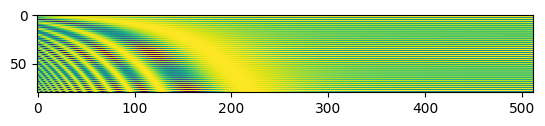

In [27]:
model.test_embedding(torch.full((80,),4))

In [26]:
0/0

ZeroDivisionError: division by zero

In [ ]:
model.testmha()

vnnres=tensor([[3., 3., 4., 4., 1., 3.],
        [3., 0., 0., 4., 4., 3.],
        [0., 3., 0., 2., 3., 0.],
        [3., 4., 3., 2., 2., 4.],
        [3., 4., 1., 3., 1., 3.]])
knnres=tensor([[4., 2., 1., 0., 1., 0.],
        [0., 1., 2., 4., 4., 1.],
        [0., 3., 3., 3., 1., 0.],
        [4., 3., 2., 4., 0., 4.],
        [4., 3., 3., 3., 0., 2.]])
qnnres=tensor([[2., 0., 3., 3., 0., 1.],
        [0., 0., 4., 0., 2., 1.],
        [1., 4., 2., 2., 1., 3.],
        [3., 1., 4., 0., 2., 3.],
        [4., 1., 3., 1., 1., 3.]])


### Pazi! Ono sto dobijes na kraju nije softmaxovano

In [ ]:

testIter = iter(testLoader)
string_preds = []
token_preds={}
logit_preds = []
NUM_OF_DIFF_TESTS = NO_EPOCHS #vrati na 1 kad zavrsis
def test():
    test_loss=0
    with torch.no_grad():
        for i in range((NO_TEST_STRINGS-1)//NUM_OF_DIFF_TESTS):
            input_string, label = next(testIter)
            label = label.long()
            #label = F.one_hot(label, vocab_size).float() #ovo je safe za mapu
            #print(f'{label.dtype=} {label=}')
            baby = model(input_string)
            #treba baby[0] uvek
            loss = criterion(input=baby,target=label)
            test_loss+=loss.sum() #msm da ovo ne treba ovk
            #print(f'{input_string.shape=} {baby[0].argmax().shape=}')
            pred_num = baby[0].argmax()
            pred_word = toker.decode(pred_num)
            string_preds.append(toker.decode(torch.cat((input_string.squeeze(),pred_num.unsqueeze(0)))))
            token_preds[pred_word] = token_preds.get(pred_word,0)+1
            logit_preds.append(baby[0])
#test()

In [ ]:
l = [0]*70000
for i,(inp,label) in enumerate(trainLoader):
  print(inp)
  print(label)
  if i==10: break

tensor([[0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2,
         0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2,
         0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1]])
tensor([2])
tensor([[0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2,
         0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2,
         0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1]])
tensor([2])
tensor([[1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
         1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0]])
tensor([1])
tensor([[1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
         1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0]])
tensor([1])
tensor([[0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2,
         0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]])
tensor([0])
tensor([[1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
         1, 2, 0, 1, 2, 0, 1, 2, 0, 

In [ ]:
def train():
    global token_preds
    for epoch in range(NO_EPOCHS):
        epoch_loss=0
        test()
        # print(f'{model.dembedder.weight[0].mean()=}')
        # print(f'{model.dembedder.weight[1].mean()=}')
        # print(f'{model.dembedder.weight[2].mean()=}')
        # print(f'{model.dembedder.weight[3000].mean()=}')

        #for s in string_preds[:10]: print(s, '\nEND')

        for logit in logit_preds[:10]: print(f'{logit=}')

        for q in list(token_preds.items()):
            print(q)
        token_preds={}

        for i in range(NO_BATCHES):
            input_string, label = next(verseIter)
            label = label.long()
            #label = F.one_hot(label, vocab_size).float() #ovo je safe za mapu
            #print(f'{label.dtype=} {label=}')
            #print(f'{input_string=}')
            baby = model(input_string)
            #print(f'{baby.argmax()=}')
            #print(f'{toker.decode(baby.argmax())=}')
            #print(f'{baby-label=}')
            loss = criterion(input=baby,target=label)
            epoch_loss+=loss.sum()
            loss.backward()
            if i==100:
                # for par in model.named_parameters():
                #     print(f'{par=}')
                #     print(f'{par[1].grad=}')
                print(f'{model.dembedder.weight.grad[0:10]=}')
            optimizer.step()
            optimizer.zero_grad()
        train_loss_dic[epoch]=epoch_loss





train()

logit=tensor([ 0.0871, -0.1376,  0.2614,  ...,  0.0767,  0.3017, -0.1164])
logit=tensor([ 0.1099, -0.1204,  0.2476,  ...,  0.0161,  0.2217, -0.0744])
logit=tensor([ 0.0331, -0.0561,  0.1321,  ...,  0.0559,  0.2202, -0.1049])
logit=tensor([ 0.0581, -0.2044,  0.1363,  ...,  0.0340,  0.1942, -0.1236])
logit=tensor([ 0.0964, -0.1613,  0.1782,  ...,  0.0011,  0.2987, -0.0476])
logit=tensor([ 0.1069, -0.0996,  0.2303,  ...,  0.0535,  0.2327, -0.0976])
logit=tensor([ 0.2164, -0.1352,  0.2257,  ...,  0.0070,  0.2519, -0.1055])
logit=tensor([ 0.0775, -0.2073,  0.2590,  ..., -0.0686,  0.1606, -0.1200])
logit=tensor([ 0.0186, -0.0767,  0.2175,  ..., -0.0513,  0.2086, -0.0718])
logit=tensor([ 0.1357, -0.0680,  0.2431,  ...,  0.0342,  0.2500, -0.0337])
(' shortage', 72)
(' Protoss', 1)
('Applic', 6)
(' tags', 12)
(' Louisiana', 33)
(' Elections', 26)
(' burnt', 1)
('Suddenly', 4)
('ician', 3)
(' Tad', 4)
(' ser', 1)
('State', 1)
(' depended', 1)
(' cath', 1)
logit=tensor([ 0.0871, -0.1376,  0.2614,

Uglavnom konvergira ka \n ili ka ,

Ups - dobio sam index error  za neki dataset. IndexError: index 1688259 is out of bounds for dimension 0 with size 1688249

In [ ]:
toker.decode(0)
toker.decode(1)
toker.decode(2)

NameError: name 'toker' is not defined

In [ ]:
print(train_loss_dic)

NameError: name 'train_loss_dic' is not defined

12 JUL: svugde stavlja uzvicnik. vrv se necega nisam setio da uradim lol

## Moras svugde da ubacis batches cim vidis da radi.